In [1]:
%matplotlib inline
import numpy as np, os
import matplotlib.pyplot as plt 
import h5py
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA

from scipy.io import loadmat
import seaborn as sns

In [3]:
def load_rois_hdf5(hdf_file='s06420190206/rois_pool4_glm.mat'):
    if not os.path.isfile(hdf_file):
        print 'file %s not found' % hdf_file

    if not os.access(hdf_file, os.R_OK):
        print 'file %s not readable' % hdf_file

    f = h5py.File(hdf_file, 'r')
    f.keys()

    # Load and extract the Instances for each ROI
    rois_mat = f

    rois = {}
    for column in rois_mat['rois']:
        roi = rois_mat[column[0]]
        instances = roi['instance']['instances']
        amps = np.array(roi['instance']['fit']['amplitude'])
        r2 = np.array(roi['instance']['r2'])[0]


        inst = {};
        for i,col in enumerate(instances):
            inst[i] = np.array(rois_mat[col[0]])
        roi_name = rois_mat[column[0]]['name'][:].tostring().decode('utf-16')
        rois[roi_name] = {};
        rois[roi_name]['instances'] = inst;
        rois[roi_name]['amplitudes'] = amps
        rois[roi_name]['r2'] = r2
    stimValues = np.array(rois_mat['stimValues'])

    return rois, stimValues

rois, stimValues = load_rois_hdf5('s06420190206/rois_pool4_glm.mat')

In [4]:
## FUNCTIONS to get voxel responses and get gram matrix features.

gm_dir = '/Users/akshay/proj/TextureSynthesis/behav_data/gram_mtx_bw'
imNames = ['bricks', 'bark', 'rocks', 'glass']
texSmps = [1,2,3,4]

def get_voxel_responses(rois):
    responses = {};
    for roi in rois.keys():
        inst = rois[roi]['instances']

        vox_resp = [];
        for I in inst.keys():
            smp = int(stimValues[I,1])            
            if smp in texSmps:
                instance = inst[I]
                vox_resp.append(instance)

        responses[roi] = np.array(vox_resp)

    return responses

def get_gram_matrices(rois, getAll=0, gm_dir = gm_dir, obs_lay='pool4', obs_rf = '1x1'):
    for roi in rois.keys():
        inst=rois[roi]['instances']

        gms = []
        for I in inst.keys():
            smp = int(stimValues[I,1])
            fam = int(stimValues[I,0])-1
            
            if smp in texSmps:
                gm = np.load('{}/gram{}_1x1_pool4_{}_smp{}.npy'.format(gm_dir, obs_rf, imNames[fam], smp)).item()
                gms.append(gm[obs_lay].ravel())
        break
    return np.array(gms)

## Fit voxel responses

In [5]:
## Extract voxel responses of specified ROI and gram matrices of specified layer.
def get_features_and_responses(rois, obs_lay='pool2', roi='V3', avg_reps=1, runPCA=1):
    responses = get_voxel_responses(rois)
    gms = get_gram_matrices(rois, obs_lay=obs_lay)

    # Can specify whether to average repeated stimuli or to keep them separate (to have more stimuli)
    if avg_reps:
        roi_resp = np.mean(responses[roi],axis=2)
        gram_matrices = gms
    else:
        # Separate out responses to each sample
        roi_resp0 = responses[roi]
        a = [roi_resp0[:,:,i] for i in range(roi_resp0.shape[2])]
        roi_resp = np.concatenate(a, axis=0)
        gram_matrices = np.concatenate((gms,)*12,axis=0)

    ## Perform PCA on the features
    if runPCA:
        pca = np.load('/Users/akshay/proj/TextureSynthesis/texpca/pool2_dims.npy').item()['pca']
        gram_matrices = pca.transform(gram_matrices)

    return roi_resp, gram_matrices

In [8]:
## Run PLS regression on each voxel (leave-one-image-out)
def predict_voxel_responses(roi_resp, gm):
    nVox = roi_resp.shape[1]; nIms = roi_resp.shape[0]
    cv_r2 = np.zeros(nVox);
    cv_preds = np.zeros((nVox, nIms))
    for vi in range(nVox):
        vox_resp = roi_resp[:,vi]

        for i in range(len(vox_resp)):
            pls = PLSRegression(n_components=10)

            # Fit on all images except the i'th
            all_but1 = np.setdiff1d(np.arange(len(vox_resp)), i)
            pls.fit(gm[all_but1, :], vox_resp[all_but1])

            # Test on the i'th image
            cv_preds[vi,i] = pls.predict(gm[i,:].reshape(1,-1))

        # compute r2
        cv_r2[vi] = compute_r2(vox_resp, cv_preds[vi,:])
        
    return cv_preds, cv_r2

def compute_r2(y_true, y_pred):
    sse = ((y_true - y_pred)**2).sum()
    ssto = ((y_true - np.mean(y_true))**2).sum()
    return 1 - (sse / ssto)



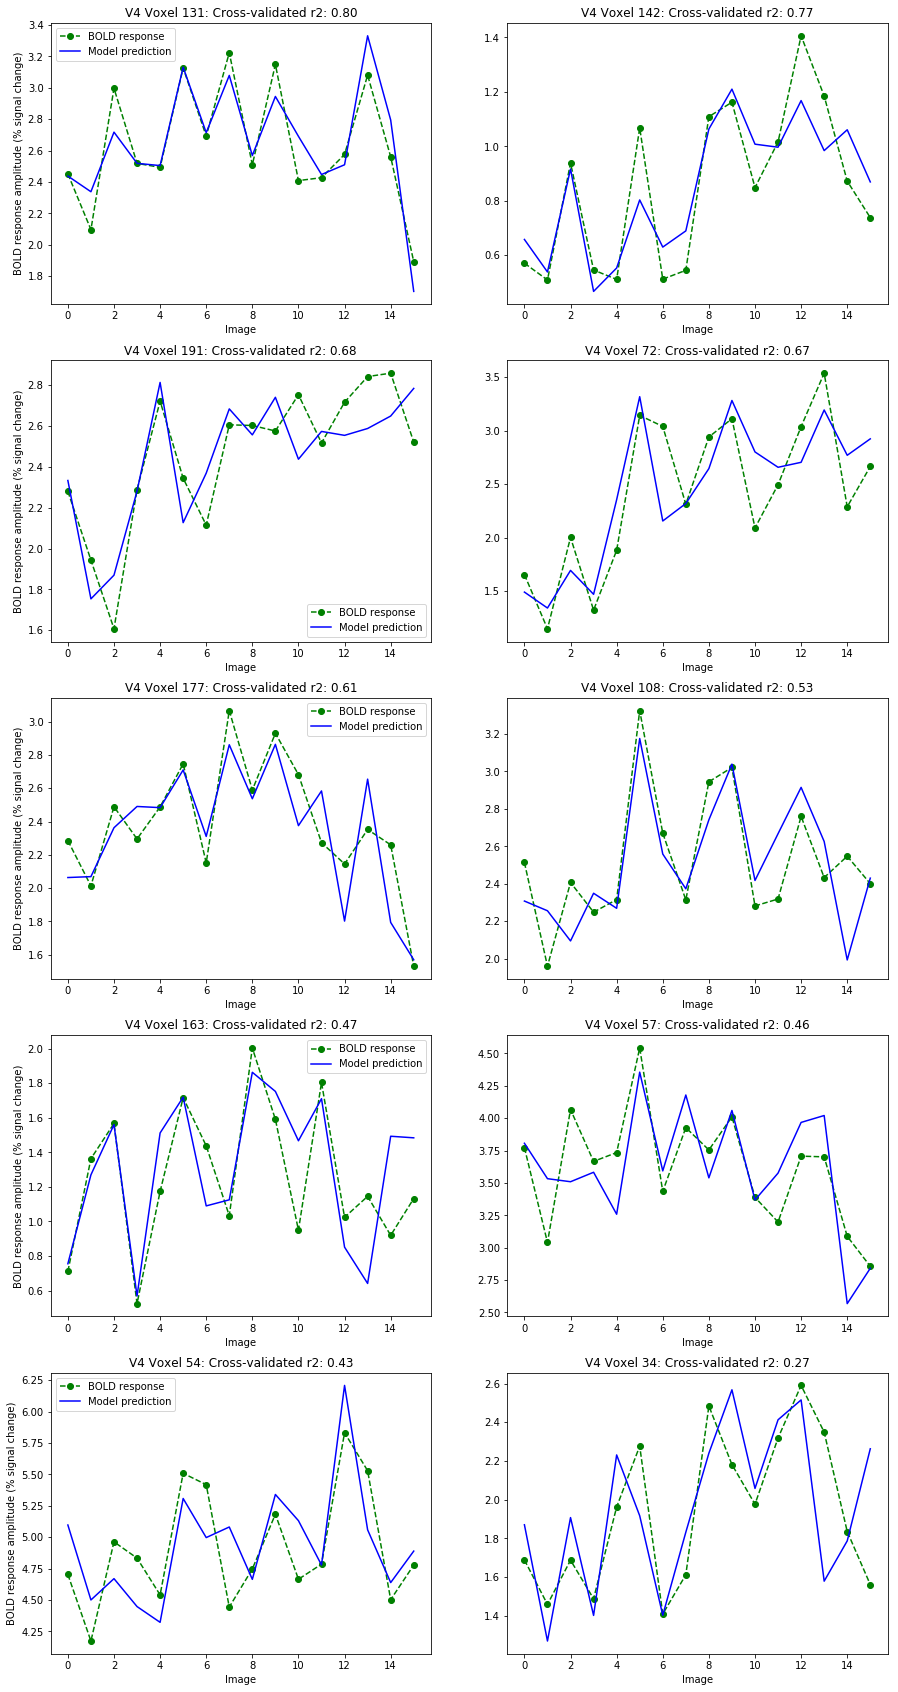

In [14]:
## Get features and responses and run!
roi = 'V4'; obs_lay='pool2';
roi_resp, gram_matrices = get_features_and_responses(rois, roi=roi, obs_lay=obs_lay, runPCA=1)
cv_preds, cv_r2 = predict_voxel_responses(roi_resp, gram_matrices)

## Plot the 10 best fitting voxels.
fig = plt.figure(figsize=(15,30))
si = np.argsort(cv_r2)[::-1]

for i in range(10):
    ind = si[i]
    
    plt.subplot(5,2,i+1)
    plt.plot(roi_resp[:,ind], 'o--g');
    plt.plot(cv_preds[ind,:], '-b');
    plt.title('{0} Voxel {1}: Cross-validated r2: {2:.2f}'.format(roi, ind, cv_r2[ind]))
    plt.xlabel('Image');
    
    if i % 2 ==0:
        plt.legend(['BOLD response', 'Model prediction'])
        plt.ylabel('BOLD response amplitude (% signal change)');
fig.savefig('/Users/akshay/proj/texER/s06420190206/Model_Fits/{}_{}_modelfit.png'.format(roi,obs_lay),
            bbox_inches='tight')

In [233]:
responses = get_voxel_responses(rois)
gms = get_gram_matrices(rois)

#a = 
#for i in range(responses['V1']):
#    a = responses['V1'][:,:,i]
np.concatenate((gms,)*12, axis=0).shape

(192, 262144)

## Representational Similarity Analysis

In [263]:
np.zeros(10)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [264]:
def get_corr_mtx(resps, returnNC=0):
    corr_mtx = np.zeros((resps.shape[0], resps.shape[0]))
    noise_ceiling = []
    nIters = 100
    for i in range(resps.shape[0]):
        respX = resps[i,:]
        for j in range(resps.shape[0]):
            respY = resps[j,:]
            if returnNC:
                corrs = np.zeros(nIters)
                for k in range(nIters):
                    smps1 = np.random.choice(respX.shape[1], respX.shape[1]/2, replace=False)
                    smps2 = np.setdiff1d(np.arange(respX.shape[1]), smps1)
                    corrs[k] = np.corrcoef(np.mean(respX[:,:(respX.shape[1]/2)],1), np.mean(respY[:,(respY.shape[1]/2):],1))[0,1]
                corr_mtx[i,j] = np.mean(corrs)
                if i==j:
                    noise_ceiling.append(corr_mtx[i,j])
            else:
                corr_mtx[i,j] = np.corrcoef(respX,respY)[0,1]
    return corr_mtx, noise_ceiling

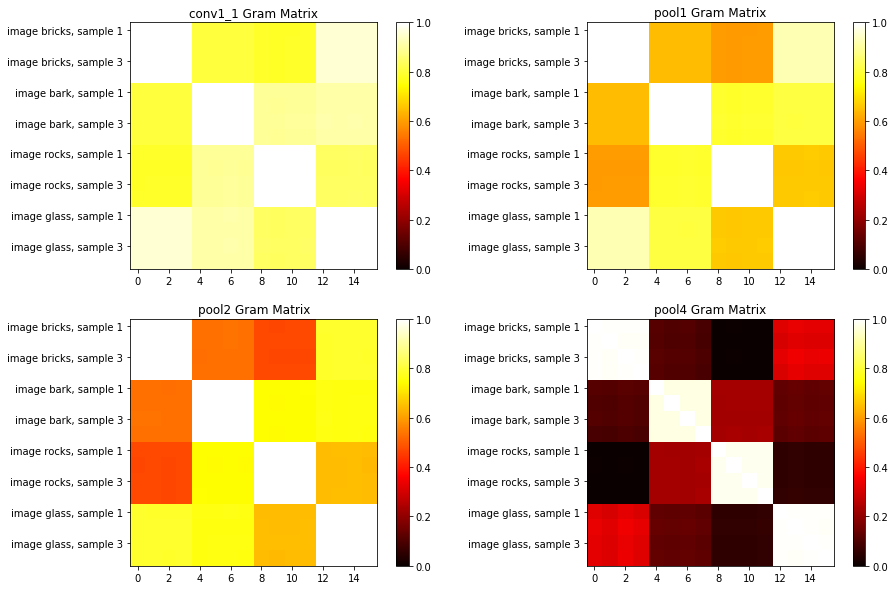

In [265]:
### Plot RDMs for VGG Model
layers = ['conv1_1', 'pool1', 'pool2', 'pool4']

fig = plt.figure(figsize=(15,10))
i=1
for lay in layers:
    GMs = get_gram_matrices(rois, obs_lay=lay)
    cm,nc = get_corr_mtx(GMs)
    ax = plt.subplot(2,2,i); i = i+1;
    plt.imshow(cm, cmap='hot')
    plt.clim(0,1)
    #plt.axis('off');
    plt.title('{} Gram Matrix'.format(lay)); 

    ax.set_yticks([k for k in np.arange(0,cm.shape[0], 2)])
    ax.set_yticklabels(['image {}, sample {}'.format(im,smp) for im in imNames for smp in np.arange(1,4,2)])
    
    #if i == len(layers)+1: 
    plt.colorbar();

#fig.savefig('/Users/akshay/proj/texER/s06420190206/04152019/model_RSA.png', bbox_inches='tight')

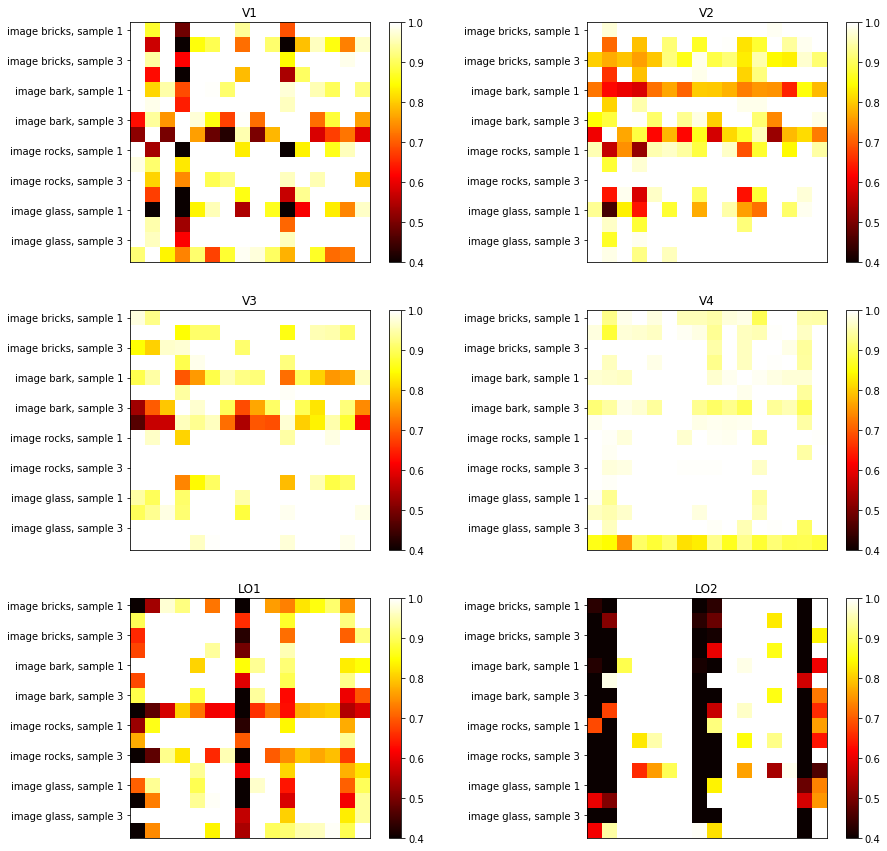

In [267]:
### Plot RDMs for brain voxels
normalizeByNC=1;

responses = get_voxel_responses(rois)
i = 1;
fig = plt.figure(figsize=(15,15))
roiNames = ['V1', 'V2', 'V3', 'V4', 'LO1', 'LO2']
for roi in roiNames:
    #roi_resp = np.mean(responses[roi],axis=2)
    cm,nc = get_corr_mtx(responses[roi],1)
    if not normalizeByNC:
        nc = 1
    ax = plt.subplot(3,2,i); i = i+1;
    plt.imshow(cm/np.mean(nc), cmap='hot')
    ax.set_xticks([])  
    ax.set_yticks([k for k in np.arange(0,cm.shape[0], 2)])
    ax.set_yticklabels(['image {}, sample {}'.format(im,smp) for im in imNames for smp in np.arange(1,4,2)])

    plt.title(roi); plt.colorbar(); plt.clim([.4,1])

#fig.savefig('/Users/akshay/proj/texER/s06420190206/04152019/brain_RSA.png', bbox_inches='tight')

In [199]:
responses = get_voxel_responses(rois)
responses['V1'].shape

(16, 200, 12)

[0.8223514466692408,
 0.7127547047799396,
 0.8693368825632098,
 0.8397224918351189,
 0.8223809852783013,
 0.8458200526094807,
 0.8214118154589956,
 0.7989018975228294,
 0.8040037344052368,
 0.8356318426758721,
 0.8493874894425653,
 0.8337807390316712,
 0.8397362150962887,
 0.8392627889466296,
 0.7339272704384631,
 0.7158867062923466]